<a href="https://colab.research.google.com/github/emmarogge/notebooks/blob/master/rolling_hash_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load FASTA data for experiment

In [1]:
# Install and load dependencies
!pip3 install biopython

import itertools
import logging
import matplotlib.pyplot as plt
import operator

from Bio import SeqIO
from io import StringIO
from itertools import cycle


# Mount drive to Colab
from google.colab import drive, files
drive.mount('/content/drive/')
! cp "/content/drive/My Drive/notebooks/thesis/2.fasta" "2.fasta"
! cat "/content/drive/My Drive/notebooks/thesis/2.fasta"
file = StringIO("/content/drive/My Drive/notebooks/thesis/2.fasta")

     |████████████████████████████████| 2.3MB 4.8MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
>2      
ATTGGGAACGGGGACACTATGCCCGACATTCGCTAAAGGAAAGTGAAAATTAGTAATGAGCAACTGAGATATTGGAAGGCTTTAATTACCATGTGATACTTGAAAAATTGAGGGCAAACAATCTATAGAACTCGGATGTAACAGATAGTCATTTCCATGGCCTACCGACAAGCCCAAATTGTCACGTTGCTCTTTGTTGGGTGCTGGAACCTCTAAAAAGCTAATTCTAAAATACGAGCTTCACGTTTGGAGTCTTGATCCAAAATAAGCGTACGCTTTTATTCGGCATACGCGCAGGTGTCAACCTTGCAGCGAATGGGATGAGGTGCAAGGAACGCATTTGCGCTGGCAATGACGCCTGGTTCACCAGTCGTACCCAAGAGCCTATTTCGGACATAT

## Set up logging

In [0]:
logging.basicConfig(filename='rolling.log', level=logging.DEBUG)

### Rabin-Karp rolling hash algorithm

Strategy 1:
Compute a rolling hash over each m-length window of 2 sequences.
Separate these hashes into 'windows', and select the minimum of each one.
Then align the windows whose minimum hashes match.

In [0]:
'''A rolling hash for a window of constant length into a text,
    both specified at construction.
'''
class RollingHash:
    adjust = ord("a") - 1
    alphabet = 4
    def __init__(self, text, size):
        '''Set up a rolling hash for a window of size into text.'''
        self.text = text
        '''
        h_i+1 = (d(h_i − t[i + 1] * d^(m−1))+ t[m + i + 1]) mod q
        '''
        rk = 0
        for c in text[:size]:
            rk = (rk * self.alphabet + (ord(c) - self.adjust))
        self.hash = rk  % 101
        self.pos = -1
        self.window_start = 0
        self.window_end = size
        self.multiplier = RollingHash.alphabet ** (size - 1)
        self.hashmap = {}

    def get_hashtable(self):
        ''' Return hashtable for text.'''
        return self.hashmap

    def get_window_hash(self):
        ''' Return hash value for current window.'''
        return self.hash

    def get_window_start(self):
        ''' Return start index for current window.'''
        print("start: {}\n".format(self.window_start))
        return self.window_start

    def get_window_end(self):
        ''' Return end index for current window.'''
        return self.window_end

    def get_window_text(self):
        '''Return current window text.'''
        return self.text[self.window_start:self.window_end]

    def move_window(self):
        '''Advance window by one position.'''
        if self.window_end < len(self.text):
            self.hash = \
                (self.hash - (ord(self.text[self.window_start])
                              - RollingHash.adjust) \
                * RollingHash.alphabet \
                + (ord(self.text[self.window_end]) - RollingHash.adjust)) % 101
            self.window_start += 1
            self.window_end += 1
            return 0
        else:
            return -1

    def match(self, other):
        '''Return position of next match.'''
        roll = self.hash
        text = self.text
        start = self.window_start
        end = self.window_end
        limit = len(self.text)
        result = None
        while end < limit:
            if self.pos < other.hash == roll \
                and other.text == text[start:end] \
                and self.pos < start:
                result = self.pos = start
                break;
            roll = (roll - (ord(text[start])
                            - RollingHash.adjust) * self.multiplier) \
                * RollingHash.alphabet \
                + ord(text[end]) - RollingHash.adjust
            start += 1
            end += 1
        self.window_start = start
        self.window_end = end
        return result

    def populate_hashtable(self):
        '''Compute hash of each substring of length n.'''
        roll = self.hash
        text = self.text
        start = self.window_start
        end = self.get_window_end()
        limit = len(self.text)
        result = None
        while end < limit:
            self.hashmap[start] = roll
            roll = (((roll - \
                    (ord(text[start]) - RollingHash.adjust)) \
                * RollingHash.alphabet \
                + (ord(text[end]) - RollingHash.adjust)) % 101)
            start += 1
            end += 1
        self.window_start = start
        self.window_end = end

## Rabin-Karp algorithm: 
Returns a list of indices at which a substring occurs in a text

In [0]:
'''
Return list of indices of matches for word in text.
'''
def rabin_karp(word, text):
    size = len(word)
    textlen = len(text)
    if not 0 < size <= textlen:
        return None
    rolling_hash = RollingHash(text, size)
    word_hash = RollingHash(word, size)
    indices = []
    while True:
        position = rolling_hash.match(word_hash)
        if position is None:
            self.move_window()
        else:
            return position


## Helper methods for constructing windows, finding window minima, and document fingerprinting.

In [0]:
'''
Given a list of lists of pairs (index, hash value), return a list of pairs
representing each time the minimum hash value in a window changes and 
the index of occurrence.
'''
def get_window_mins_no_repeats(table, m):
    # Obtain list of tuples (window_start_index, (window_end_index, window_min))
    windows = [(index, table[(index):(index + m)]) for index in range(0, len(table) - m, 1)]
    window_mins = []
    for ix, w in enumerate(windows):
        # print("ix {}: w {}".format(ix, w))
        winmin = min(w[1], key = operator.itemgetter(1)) 
        window_mins.append((ix, winmin))
    mins = {}
    # Loop through each tuple, updating mins when minimum in window changes
    for ix in range(len(window_mins)):
        if ix > 0:
            prev_min = window_mins[ix - 1] 
            curr_min = window_mins[ix]
            if prev_min[1][1] == curr_min[1][1]:
                logging.debug("Same minimum as previous window.")
            # If new minimum, record start, end indices of window & min value
            else: 
                if curr_min[1][1] not in mins.keys():
                    mins[curr_min[1][1]] = list((curr_min[0], curr_min[1][0]))
                else:
                    mins[curr_min[1][1]].append((curr_min[0], curr_min[1][0]))
        else:
            mins[window_mins[0][1][1]] = list((window_mins[0][0], window_mins[0][1][0]))

    print("Minima: {}".format(mins))
    return mins

'''
Return a list of the window minimums for the given text and window size.
'''
def document_fingerprint_by_chunk(text, roll_size, window_size):
    rh = RollingHash(text, roll_size)
    rh.populate_hashtable()
    table = list(rh.get_hashtable().items())
    ms = get_window_mins_no_repeats(table, window_size)
    return ms

## HashAlignment class: 
## Computes the alignment between two sequences via segmentation and hashing

Unknowns:
- What is the optimal size for the rolling hash window?
- What is the optimal number of hashes from which to take the minimum?
- Does this approach result in a meaningful alignment:
    - For DNA?
    - For other applications, e.g. plagiarism?

In [163]:
# %%capture
!pip install adjustText

# Load sequences for alignment from files
seqs = []
for seq_record in SeqIO.parse("2.fasta", "fasta"):
    seqs.append(str(seq_record.seq))

# Class to compute the alignment.
class HashAlignment():
    
    def __init__(self, a, b, roll_size, win_size):
        self.roll_size = roll_size
        self.win_size = win_size
        self.a_mins = document_fingerprint_by_chunk(a, roll_size, win_size)
        self.b_mins = document_fingerprint_by_chunk(b, roll_size, win_size)
        self.b_alignment = {}
        self.no_match = 1
        self.match = 0

    '''
    Return % of segments for which match is found.
    '''
    def get_percent_matched(self):
        return float(self.match) / float(self.match + self.no_match)

    def get_a_mins(self):
        return self.a_mins

    def get_b_mins(self):
        return self.b_mins
    
    def print_minima(self):
        print("____MINIMA_____")
        print("A: {}".format(self.a_mins))
        print("B: {}".format(self.b_mins))

    '''
    Tally the number of segments for which a match has been found
    '''
    def approximate_num_matching_segments(self):
        aset = set(self.a_mins.keys())
        bset = set(self.b_mins.keys())
        result = aset.intersection(bset)
        return len(result)

    def alignment(self):
        match = self.match
        no_match = self.no_match - 1
        a_to_b = []
        amins = self.get_a_mins()
        bmins = self.get_b_mins()
        for h, ix in amins.items():
            if h in bmins:
                bix = bmins[h]
                a_to_b.append([ix, bix])
                print("A({},{}): {}".format(ix[0], ix[1], seqs[0][ix[0]:ix[1]]))
                print("B({},{}): {}".format(bix[0], bix[1], seqs[1][bix[0]:bix[1]]))
            else:
                
        # Loop back through to insert segments of B in place that do not have matches.


## Create alignment from segments

In [164]:
import operator
ha = HashAlignment(seqs[0][0:300], seqs[1][0:300], 15, 12)
ha.print_minima()
ha.alignment()
ha.get_a_mins()[0]
a_lst = [(k, v[0], v[1]) for k, v in ha.a_mins.items()]
a_lst.sort(key = lambda x : x[1])

blst = []
for ix in range(len(a_lst)):
    hash = a_lst[ix][0]
    if hash in ha.b_mins.keys():
        blst.append((hash, ha.b_mins[hash][0], ha.b_mins[hash][1]))
    else:
        blst.append(None)

for a, b in zip(a_lst, blst):
    if b != None:
        abps = seqs[0][a[1]:a[2]]
        bbps = seqs[1][b[1]:b[2]]
        print("A: {}\nB: {}".format(abps, bbps))

Minima: {2: [0, 5, (81, 92), (98, 109), (195, 206)], 23: [6, 7], 3: [7, 18, (264, 267)], 0: [10, 21, (202, 213)], 13: [22, 31], 9: [26, 37, (78, 89), (249, 253)], 10: [38, 38, (62, 73), (214, 219)], 15: [39, 48], 18: [49, 54], 17: [53, 64, (114, 119), (145, 154), (268, 271)], 25: [76, 78], 4: [93, 100, (121, 132), (171, 182), (221, 232)], 1: [102, 113, (252, 263)], 22: [120, 131, (155, 165)], 6: [133, 133, (191, 199), (235, 235), (237, 248)], 7: [134, 141, (163, 174)], 8: [142, 144], 14: [236, 246], 29: [272, 277]}
Minima: {3: [0, 10, (216, 227), (269, 280)], 6: [11, 11, (79, 90)], 12: [12, 18], 13: [19, 22, (46, 48), (152, 159)], 34: [23, 26], 40: [27, 34], 11: [28, 39, (104, 115), (120, 122), (135, 146), (197, 208), (245, 253), (255, 266)], 5: [30, 41, (203, 214), (230, 241)], 4: [34, 45], 18: [49, 55], 24: [56, 60], 17: [61, 72, (187, 194)], 14: [68, 79, (215, 215), (254, 258)], 1: [84, 95, (172, 183)], 8: [96, 101, (184, 185)], 21: [102, 111, (123, 125)], 10: [108, 119, (140, 151)]

## Perform a parameter search to determine optimal roll size and window size for alignment

Test data is FASTA mammalian mitochodrion genomes.

mins: {69: (2387, 2387), 72: (2063, 2063), 2: (2407, 2407), 25: (2381, 2381), 70: (2401, 2401), 52: (2420, 2420), 81: (2100, 2100), 19: (2432, 2432), 74: (2392, 2392), 78: (2372, 2372), 80: (2409, 2409), 86: (2444, 2444), 11: (2456, 2456), 31: (2451, 2451), 15: (2416, 2416), 63: (2457, 2457), 48: (2185, 2185), 77: (2403, 2403), 24: (2434, 2434), 90: (2435, 2435), 27: (2436, 2436), 92: (2427, 2427), 68: (2378, 2378), 57: (2271, 2271), 20: (2464, 2464), 21: (2279, 2279), 0: (2366, 2366), 85: (2422, 2422), 5: (2437, 2437), 10: (2447, 2447), 42: (2301, 2301), 59: (2399, 2399), 26: (2452, 2452), 97: (2466, 2466), 83: (2441, 2441), 76: (2241, 2241), 95: (2281, 2281), 64: (2389, 2389), 65: (2350, 2350), 50: (2459, 2459), 96: (2349, 2349), 98: (2454, 2454), 18: (1949, 1949), 66: (2364, 2364), 79: (2455, 2455), 82: (2348, 2348), 40: (2180, 2180), 51: (2339, 2339), 73: (2468, 2468), 58: (2469, 2469), 41: (2263, 2263), 7: (2304, 2304), 6: (2323, 2323), 12: (2358, 2358), 32: (2431, 2431), 29: (247

KeyboardInterrupt: ignored

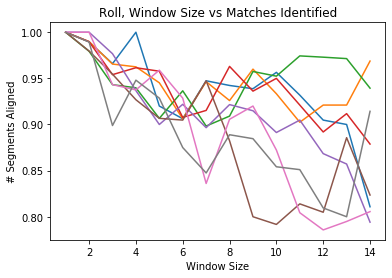

In [75]:
  def grid_search():
    plt.figure()
    plt.title("Roll, Window Size vs Matches Identified")
    num_alignments = {}
    j_lst = {}
    plt.xlabel("Window Size")
    plt.ylabel("# Segments Aligned")
    labels = []
    lines = []
    # Loop through roll sizes between 3 and 10 base pairs.
    for i in range(5, 50, 5):
        j_lst[i] = []
        num_alignments[i] = []
        grid_search = {}
        str_i = str(i)
        # Loop through window sizes
        for j in range(1, 15, 1):
            j_lst[i].append(j)
            aligner = HashAlignment(seqs[0], seqs[1], i, j)
            aligner.alignment()
            num_alignments[i].append(aligner.get_percent_matched())
            # print("Matches: {}".format(aligner.get_percent_matched()))  
        label_i = "Roll Size = {}".format(i)
        ln = plt.plot(j_lst[i], num_alignments[i], label=label_i)
    plt.legend(loc='right',bbox_to_anchor=(1.25, 0.5), borderaxespad=0.)
    plt.show()
grid_search()